In [ ]:
from typing import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
SEQUENCE_LENGTH = 10
EMBEDDING_SIZE = 8

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
START_TOKEN = "<START>"
END_TOKEN = "<END>"

In [5]:
sentences = [
    "Witcher 4 is comming out soon",
    "Learning PyTorch is fun",
    "Running is even more fun",
    "Testing the truncation of the sentnces so this is a long one",
    "Soon there will be a new year",
]

frequencies = defaultdict(int)
for sentence in sentences:
    for word in sentence.split():
        frequencies[word] += 1

frequencies_sorted = {
    k: v for k, v in sorted(frequencies.items(), key=lambda item: item[1], reverse=True)
}  # I want most common words to have the lowest token index

word_to_idx = {word: i for i, word in enumerate(frequencies_sorted.keys())}
for token in [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN]:
    word_to_idx[token] = len(word_to_idx)
idx_to_word = {v: k for k, v in word_to_idx.items()}

vocab_size = len(word_to_idx)

word_to_idx

{'is': 0,
 'fun': 1,
 'the': 2,
 'a': 3,
 'Witcher': 4,
 '4': 5,
 'comming': 6,
 'out': 7,
 'soon': 8,
 'Learning': 9,
 'PyTorch': 10,
 'Running': 11,
 'even': 12,
 'more': 13,
 'Testing': 14,
 'truncation': 15,
 'of': 16,
 'sentnces': 17,
 'so': 18,
 'this': 19,
 'long': 20,
 'one': 21,
 'Soon': 22,
 'there': 23,
 'will': 24,
 'be': 25,
 'new': 26,
 'year': 27,
 '<PAD>': 28,
 '<UNK>': 29,
 '<START>': 30,
 '<END>': 31}

In [6]:
def tokenizer(
    sentences: list[str] | str, add_start_token=True, add_end_token=True
) -> list[list[int]] | list[int]:
    def process_single(sentence: str) -> list[int]:
        tokens = [
            word_to_idx.get(word, word_to_idx[UNK_TOKEN]) for word in sentence.split()
        ]
        if add_start_token:
            tokens.insert(0, word_to_idx[START_TOKEN])
        if add_end_token:
            tokens.append(word_to_idx[END_TOKEN])
        return tokens

    if isinstance(sentences, str):
        return process_single(sentences)

    return [process_single(sentence) for sentence in sentences]

In [7]:
def pad_sequence(tokens):
    if isinstance(tokens[0], int):
        tokens = tokens[:SEQUENCE_LENGTH]
        return torch.tensor(
            tokens + [word_to_idx[PAD_TOKEN]] * (SEQUENCE_LENGTH - len(tokens))
        )

    padded_sequences = []
    for seq in tokens:
        if len(seq) >= SEQUENCE_LENGTH:
            seq = seq[: SEQUENCE_LENGTH - 1] + [word_to_idx[END_TOKEN]]
        else:
            seq = seq + [word_to_idx[PAD_TOKEN]] * (SEQUENCE_LENGTH - len(seq))
        padded_sequences.append(seq)

    return torch.tensor(padded_sequences)

In [8]:
tokens = tokenizer(sentences)
tokens

[[30, 4, 5, 0, 6, 7, 8, 31],
 [30, 9, 10, 0, 1, 31],
 [30, 11, 0, 12, 13, 1, 31],
 [30, 14, 2, 15, 16, 2, 17, 18, 19, 0, 3, 20, 21, 31],
 [30, 22, 23, 24, 25, 3, 26, 27, 31]]

In [9]:
padded_tokens = pad_sequence(tokens).to(device)
padded_tokens

tensor([[30,  4,  5,  0,  6,  7,  8, 31, 28, 28],
        [30,  9, 10,  0,  1, 31, 28, 28, 28, 28],
        [30, 11,  0, 12, 13,  1, 31, 28, 28, 28],
        [30, 14,  2, 15, 16,  2, 17, 18, 19, 31],
        [30, 22, 23, 24, 25,  3, 26, 27, 31, 28]])

In [10]:
for tokens in padded_tokens.tolist():
    print(" ".join([idx_to_word[idx] for idx in tokens]))

<START> Witcher 4 is comming out soon <END> <PAD> <PAD>
<START> Learning PyTorch is fun <END> <PAD> <PAD> <PAD> <PAD>
<START> Running is even more fun <END> <PAD> <PAD> <PAD>
<START> Testing the truncation of the sentnces so this <END>
<START> Soon there will be a new year <END> <PAD>


In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, sequence_length, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, device=device)
        self.positional_encodings = self.get_positional_encodings(
            sequence_length, embedding_size
        )

    @staticmethod
    def get_positional_encodings(sequence_length, embedding_size):
        positions = torch.arange(sequence_length).unsqueeze(1)
        i = torch.arange(embedding_size)

        divisor = torch.pow(10000, 2 * i / embedding_size)

        position_embeddings_even = torch.sin(positions / divisor)
        position_embeddings_odd = torch.cos(positions / divisor)

        return torch.where(
            i % 2 == 0, position_embeddings_even, position_embeddings_odd
        ).to(device)

    def forward(self, x):
        return self.embedding(x) + self.positional_encodings

In [12]:
embedding_layer = EmbeddingLayer(vocab_size, EMBEDDING_SIZE)
embeddings = embedding_layer(padded_tokens)

print(embeddings.shape)
print(embeddings[0])

torch.Size([5, 10, 8])
tensor([[ 1.0250, -1.0911, -0.2732, -0.4940,  0.9226, -0.5340, -0.0566,  0.5091],
        [-1.3756,  0.2060,  0.3390,  1.4635,  0.4623,  1.0437,  1.3623, -1.1151],
        [-1.4520,  0.7619, -0.8061,  0.0375,  1.4173, -1.1123,  0.1571, -0.5989],
        [ 2.7112, -1.4393,  1.6630,  0.2173, -1.4697, -1.0920,  1.4321,  1.1023],
        [ 0.2674, -0.1725, -0.4911,  0.3381,  1.9080, -0.2055,  0.7215, -0.1591],
        [ 0.7945, -1.7418, -0.4907,  0.4025,  0.1089,  0.4781,  0.7342, -0.6762],
        [-0.4057,  2.3438,  0.5534, -1.1673, -0.1960,  0.5894,  0.5876, -0.5473],
        [ 1.4798, -0.1479,  0.7109,  0.2470, -2.2685,  0.7491, -0.5046, -0.5496],
        [ 0.1592, -0.6908, -1.0259, -1.1296, -0.9412, -1.0559,  0.4717, -0.2453],
        [ 0.1592, -0.6908, -1.0259, -1.1296, -0.9412, -1.0559,  0.4717, -0.2453]],
       grad_fn=<SelectBackward0>)


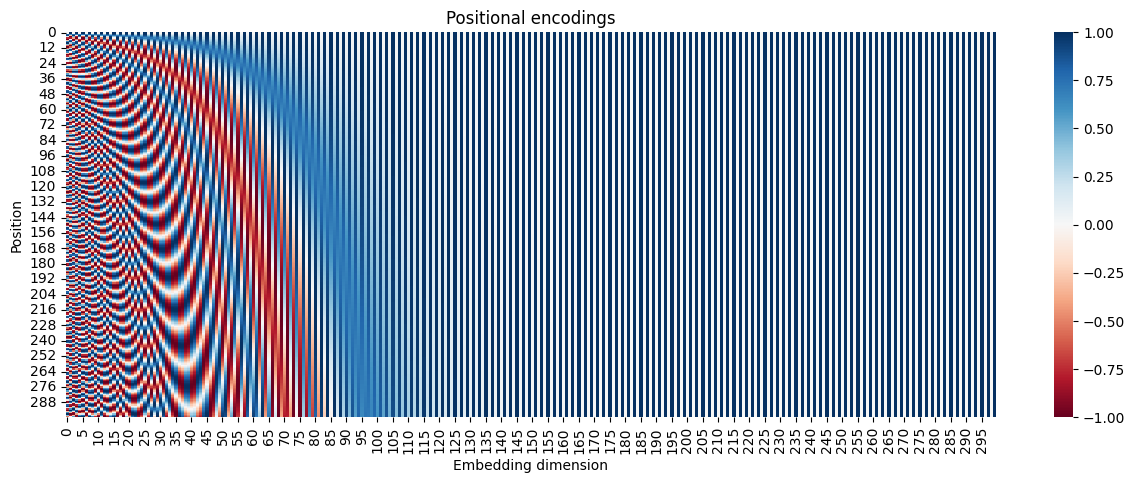

In [ ]:
plt.figure(figsize=(15, 5))
sns.heatmap(EmbeddingLayer.get_positional_encodings(300, 300), cmap="RdBu", center=0)
plt.title("Positional encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Position")
plt.show()

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, sequence_length, embedding_size, num_heads, mask=True):
        super().__init__()

        assert embedding_size % num_heads == 0, (
            "embedding_size must be divisible by num_heads"
        )

        self.mask = mask
        self.num_heads = num_heads
        self.head_size = embedding_size // num_heads
        self.sequence_length = torch.tensor(sequence_length)

        self.embedding_size = torch.tensor(embedding_size)
        self.query_dense = nn.Linear(embedding_size, embedding_size)
        self.key_dense = nn.Linear(embedding_size, embedding_size)
        self.value_dense = nn.Linear(embedding_size, embedding_size)
        self.output_dense = nn.Linear(embedding_size, embedding_size)

    def split_heads(self, x):
        B, _, _ = x.size()
        return x.view(
            B, self.sequence_length, self.num_heads, self.head_size
        ).transpose(1, 2)

    def forward(self, x):
        B, _, _ = x.size()

        Q_heads = self.split_heads(self.query_dense(x))  # (B, H, S, E/H)
        K_heads = self.split_heads(self.key_dense(x))  # (B, H, S, E/H)
        V_heads = self.split_heads(self.value_dense(x))  # (B, H, S, E/H)

        attention = (Q_heads @ K_heads.transpose(-2, -1)) / torch.sqrt(
            self.embedding_size
        )  # (B, H, S, S)

        if self.mask:
            attention = attention.masked_fill(
                torch.tril(
                    torch.ones(
                        self.sequence_length,
                        self.sequence_length,
                        device=attention.device,
                    )
                )
                == 0,
                float("-inf"),
            )

        attention = F.softmax(attention, dim=-1) @ V_heads  # (B, H, S, E/H)

        return self.output_dense(
            attention.transpose(1, 2).contiguous().view(B, self.sequence_length, -1)
        )  # (B, S, E)

In [16]:
attention_layer = AttentionLayer(
    sequence_length=SEQUENCE_LENGTH, embedding_size=EMBEDDING_SIZE, num_heads=4
)
attention_output = attention_layer(embeddings)

print(attention_output.shape)
print(attention_output[0])

torch.Size([5, 10, 8])
tensor([[ 0.2476, -0.0118,  0.2290, -0.1760,  0.3950,  0.2756,  0.1567, -0.1597],
        [ 0.2243, -0.1031,  0.2147,  0.3274,  0.2517, -0.0317,  0.3159, -0.1844],
        [ 0.3055,  0.0130,  0.2566,  0.2682,  0.2301,  0.0359,  0.2314, -0.2528],
        [ 0.2524, -0.1607,  0.1713,  0.2013,  0.2404, -0.0809,  0.2930, -0.2499],
        [ 0.1762, -0.1286,  0.2162,  0.1661,  0.2129,  0.0072,  0.2455, -0.1718],
        [ 0.1633, -0.1104,  0.1848,  0.1679,  0.2791, -0.0206,  0.2464, -0.1975],
        [ 0.2098, -0.1518,  0.2632,  0.2311,  0.2388, -0.0225,  0.2504, -0.2006],
        [ 0.2254, -0.1767,  0.2052,  0.3012,  0.2852, -0.1564,  0.2874, -0.2720],
        [ 0.2230, -0.1633,  0.2388,  0.2554,  0.3090, -0.0868,  0.2330, -0.2391],
        [ 0.2555, -0.1364,  0.2420,  0.2554,  0.3320, -0.0837,  0.2281, -0.2593]],
       grad_fn=<SelectBackward0>)


In [17]:
class FeedForward(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, embedding_size)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        return x

In [18]:
class TransformerBlock(nn.Module):
    def __init__(self, sequence_length, embedding_size, num_heads):
        super().__init__()
        self.attention_layer_1 = AttentionLayer(
            sequence_length, embedding_size, num_heads, mask=True
        )
        self.attention_layer_2 = AttentionLayer(
            sequence_length, embedding_size, num_heads, mask=False
        )
        self.layer_norm_1 = nn.LayerNorm(embedding_size)
        self.layer_norm_2 = nn.LayerNorm(embedding_size)
        self.layer_norm_3 = nn.LayerNorm(embedding_size)
        self.feed_forward = FeedForward(embedding_size, embedding_size)

    def forward(self, x):
        x = self.attention_layer_1(x) + x
        x = self.layer_norm_1(x)
        x = self.attention_layer_2(x) + x
        x = self.layer_norm_2(x)
        x = self.feed_forward(x) + x
        x = self.layer_norm_3(x)
        return x

In [19]:
transformer_block = TransformerBlock(
    sequence_length=SEQUENCE_LENGTH, embedding_size=EMBEDDING_SIZE, num_heads=4
)
transformer_block(embeddings)[0]

tensor([[ 1.5070, -1.6401, -0.7192, -0.7301,  1.3305, -0.0461, -0.1442,  0.4423],
        [-1.5607, -0.5981, -0.3374,  1.0201, -0.0938,  1.0716,  1.4261, -0.9279],
        [-1.4405,  0.3433, -1.0027,  0.2940,  1.9040, -0.7518,  0.7212, -0.0675],
        [ 1.5734, -1.3992,  0.5856, -0.2329, -1.4162, -0.4738,  0.7521,  0.6110],
        [ 0.1726, -1.1379, -1.2966,  0.0504,  2.1144, -0.0358,  0.5719, -0.4389],
        [ 0.8817, -2.0798, -0.8134,  0.4316,  0.0527,  1.0014,  0.9356, -0.4099],
        [-0.5247,  1.7527, -0.0151, -1.6206, -0.6034,  0.9609,  0.6325, -0.5821],
        [ 1.4523, -0.4151,  0.3221,  0.1457, -2.0868,  1.0597, -0.2100, -0.2678],
        [ 1.4043, -0.7350, -1.2755, -0.9794, -0.5727,  0.0284,  1.4548,  0.6753],
        [ 1.4101, -0.7302, -1.2935, -0.9786, -0.5849,  0.0689,  1.4271,  0.6810]],
       grad_fn=<SelectBackward0>)

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self, sequence_length, vocab_size, num_layers, embedding_size, num_heads
    ):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(
            sequence_length, vocab_size, embedding_size
        )
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerBlock(sequence_length, embedding_size, num_heads)
                for _ in range(num_layers)
            ]
        )
        self.output_layer = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        x = self.embedding_layer(x)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.output_layer(x)
        return F.softmax(x, dim=-1)

In [21]:
transformer = Transformer(
    sequence_length=SEQUENCE_LENGTH,
    vocab_size=vocab_size,
    num_layers=2,
    embedding_size=EMBEDDING_SIZE,
    num_heads=4,
)

print(transformer(padded_tokens).shape)
print(transformer(padded_tokens)[0])

torch.Size([5, 10, 32])
tensor([[0.0689, 0.0280, 0.0378, 0.0207, 0.0268, 0.0456, 0.0087, 0.0952, 0.0309,
         0.0274, 0.0228, 0.0619, 0.0237, 0.0083, 0.0124, 0.0121, 0.0088, 0.0456,
         0.0206, 0.0282, 0.0590, 0.0346, 0.0253, 0.0302, 0.0175, 0.0235, 0.0738,
         0.0290, 0.0167, 0.0214, 0.0182, 0.0166],
        [0.0610, 0.0359, 0.0222, 0.0358, 0.0343, 0.0199, 0.0105, 0.0750, 0.0228,
         0.0716, 0.0197, 0.0581, 0.0259, 0.0112, 0.0094, 0.0175, 0.0123, 0.0677,
         0.0185, 0.0348, 0.0666, 0.0269, 0.0217, 0.0255, 0.0104, 0.0372, 0.0510,
         0.0154, 0.0183, 0.0237, 0.0143, 0.0251],
        [0.0834, 0.0530, 0.0412, 0.0182, 0.0157, 0.0387, 0.0218, 0.0479, 0.0181,
         0.0341, 0.0244, 0.0230, 0.0373, 0.0093, 0.0142, 0.0263, 0.0087, 0.0482,
         0.0243, 0.0330, 0.1182, 0.0233, 0.0160, 0.0512, 0.0157, 0.0288, 0.0304,
         0.0116, 0.0177, 0.0109, 0.0214, 0.0340],
        [0.1081, 0.0642, 0.0394, 0.0361, 0.0187, 0.0437, 0.0197, 0.1108, 0.0257,
         0.0211,

In [22]:
x_train = []
y_train = []

for sentence in sentences:
    tokenized_sentence = tokenizer(sentence)
    for i in range(1, len(tokenized_sentence)):
        x_ngram = tokenized_sentence[:i]
        y_ngram = tokenized_sentence[i]

        x_train.append(x_ngram)
        y_train.append(y_ngram)

x_train = pad_sequence(x_train)
y_train = torch.tensor(y_train)
x_train, y_train

(tensor([[30, 28, 28, 28, 28, 28, 28, 28, 28, 28],
         [30,  4, 28, 28, 28, 28, 28, 28, 28, 28],
         [30,  4,  5, 28, 28, 28, 28, 28, 28, 28],
         [30,  4,  5,  0, 28, 28, 28, 28, 28, 28],
         [30,  4,  5,  0,  6, 28, 28, 28, 28, 28],
         [30,  4,  5,  0,  6,  7, 28, 28, 28, 28],
         [30,  4,  5,  0,  6,  7,  8, 28, 28, 28],
         [30, 28, 28, 28, 28, 28, 28, 28, 28, 28],
         [30,  9, 28, 28, 28, 28, 28, 28, 28, 28],
         [30,  9, 10, 28, 28, 28, 28, 28, 28, 28],
         [30,  9, 10,  0, 28, 28, 28, 28, 28, 28],
         [30,  9, 10,  0,  1, 28, 28, 28, 28, 28],
         [30, 28, 28, 28, 28, 28, 28, 28, 28, 28],
         [30, 11, 28, 28, 28, 28, 28, 28, 28, 28],
         [30, 11,  0, 28, 28, 28, 28, 28, 28, 28],
         [30, 11,  0, 12, 28, 28, 28, 28, 28, 28],
         [30, 11,  0, 12, 13, 28, 28, 28, 28, 28],
         [30, 11,  0, 12, 13,  1, 28, 28, 28, 28],
         [30, 28, 28, 28, 28, 28, 28, 28, 28, 28],
         [30, 14, 28, 28, 28, 2

In [ ]:
num_epochs = 1000
learning_rate = 0.001

optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


for epoch in range(num_epochs):
    optimizer.zero_grad()
    transformer.train()

    inputs = x_train.to(device)
    targets = y_train.to(device)

    outputs = transformer(inputs)
    outputs = outputs[:, -1, :]

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [50/1000], Loss: 3.4410
Epoch [100/1000], Loss: 3.3951
Epoch [150/1000], Loss: 3.3012
Epoch [200/1000], Loss: 3.2235
Epoch [250/1000], Loss: 3.1548
Epoch [300/1000], Loss: 3.1124
Epoch [350/1000], Loss: 3.0657
Epoch [400/1000], Loss: 3.0014
Epoch [450/1000], Loss: 2.9243
Epoch [500/1000], Loss: 2.8735
Epoch [550/1000], Loss: 2.8503
Epoch [600/1000], Loss: 2.8418
Epoch [650/1000], Loss: 2.8373
Epoch [700/1000], Loss: 2.8344
Epoch [750/1000], Loss: 2.8314
Epoch [800/1000], Loss: 2.8173
Epoch [850/1000], Loss: 2.8080
Epoch [900/1000], Loss: 2.8059
Epoch [950/1000], Loss: 2.8045
Epoch [1000/1000], Loss: 2.8030


In [24]:
def generate_text(sentence: str) -> str:
    tokens = tokenizer(sentence)
    input = pad_sequence(tokens).unsqueeze(0).to(device)
    input[input == word_to_idx[END_TOKEN]] = word_to_idx[PAD_TOKEN]
    num_tokens = len(tokens)

    for i in range(SEQUENCE_LENGTH - num_tokens):
        next_token_distribution = transformer(input)[:, -1, :]
        next_token = torch.argmax(next_token_distribution, dim=-1)
        input[..., num_tokens + i - 1] = next_token

    text = " ".join(
        [
            idx_to_word[idx]
            for idx in input[0].tolist()
            if idx_to_word[idx] not in [PAD_TOKEN, END_TOKEN, START_TOKEN]
        ]
    )

    return text

In [25]:
generate_text("Witcher")

'Witcher 4 is comming soon'